In [115]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [119]:
# load calibration error
DATAPATH = '../output_from_datalab/accuracy_estimation_error'
PSEUDOCOUNT = [0.1, 1, 10]
NUM_RUNS = 10
DATASET_LIST = ['imagenet', 'dbpedia', 'cifar100', '20newsgroup', 'svhn', 'imagenet2_topimages'] 
METRIC_LIST = ['weighted_pool_error', 'weighted_online_error', 'unweighted_error', 'pool_ece', 'online_ece']

def get_metric_filename(metric, dataset, pseudo_n, model_type):
    # fix some errors when writing the outputs to files
    if metric in ['pool_ece', 'mce', 'online_ece'] and model_type == 'frequentist':
        return "%s/%s%s_PseudoCount%.1f_runs%d_%s.csv" % (
                DATAPATH, metric, dataset, pseudo_n, NUM_RUNS, model_type)        
    else:
        return "%s/%s_%s_PseudoCount%.1f_runs%d_%s.csv" % (
                DATAPATH, metric, dataset, pseudo_n, NUM_RUNS, model_type)

In [120]:
N_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
header = ['dataset', 'metric', 'model_type', 'pseudo_n'] + N_list
results = []

In [121]:
for metric in METRIC_LIST:
    for dataset in DATASET_LIST:
        for pseudo_n in PSEUDOCOUNT:
            params = [dataset, pseudo_n]
            bayesian_result = np.mean(np.genfromtxt(get_metric_filename(metric, dataset, pseudo_n, 'bayesian')
                                                    , delimiter=","), axis=0).tolist()
            frequentist_result = np.mean(np.genfromtxt(get_metric_filename(metric, dataset, pseudo_n, 'frequentist')
                                                       , delimiter=","), axis=0).tolist()
            if len(bayesian_result) < len(N_list):
                bayesian_result.append(-1)
                frequentist_result.append(-1)
            results.append([dataset, metric, 'bayesian', pseudo_n] + bayesian_result)
        results.append([dataset, metric, 'frequentist', 0] + frequentist_result)

In [123]:
results =  pd.DataFrame(results, columns=header)
results.to_csv('../output_from_datalab/results.csv')
results

,dataset,metric,model_type,pseudo_n,10,20,50,100,200,500,1000,2000,5000,10000
0,imagenet,weighted_pool_error,bayesian,0.1,0.139118,0.131491,0.106357,0.083706,0.060351,0.030852,0.023789,0.018729,0.010757,0.007620
1,imagenet,weighted_pool_error,bayesian,1.0,0.103762,0.098418,0.081729,0.069304,0.054738,0.029955,0.023370,0.018532,0.010704,0.007612
2,imagenet,weighted_pool_error,bayesian,10.0,0.047634,0.050489,0.041443,0.036057,0.033748,0.024849,0.020439,0.017136,0.010335,0.007543
3,imagenet,weighted_pool_error,frequentist,0.0,0.240259,0.191722,0.121216,0.087239,0.061372,0.031015,0.023854,0.018761,0.010763,0.007621
4,dbpedia,weighted_pool_error,bayesian,0.1,0.004150,0.004742,0.004968,0.005505,0.004947,0.004567,0.004480,0.003268,0.001850,0.001346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,svhn,online_ece,frequentist,0.0,0.085000,0.073500,0.059400,0.054700,0.048350,0.043900,0.042460,0.041650,0.039998,0.039282
116,imagenet2_topimages,online_ece,bayesian,0.1,0.195699,0.132058,0.088350,0.063138,0.051467,0.036671,0.036033,0.029497,0.027392,0.026246
117,imagenet2_topimages,online_ece,bayesian,1.0,0.136407,0.097005,0.069566,0.054568,0.047789,0.035444,0.035456,0.029255,0.027308,0.026206
118,imagenet2_topimages,online_ece,bayesian,10.0,0.040053,0.033418,0.029036,0.027731,0.031180,0.027595,0.031085,0.027241,0.026546,0.025837


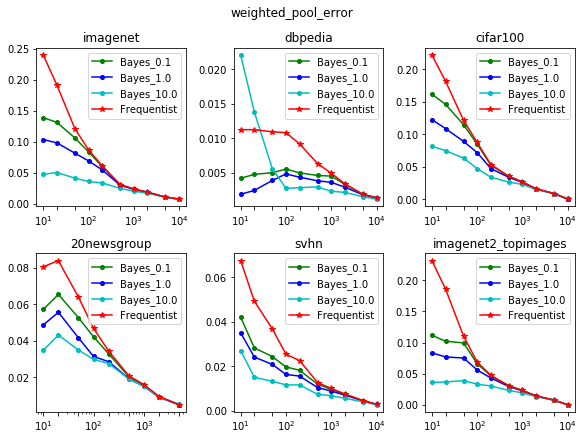

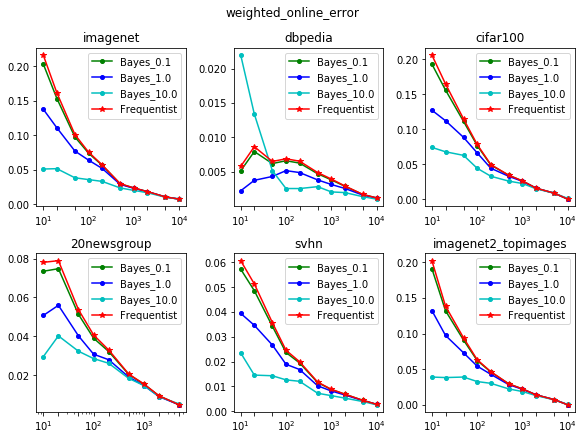

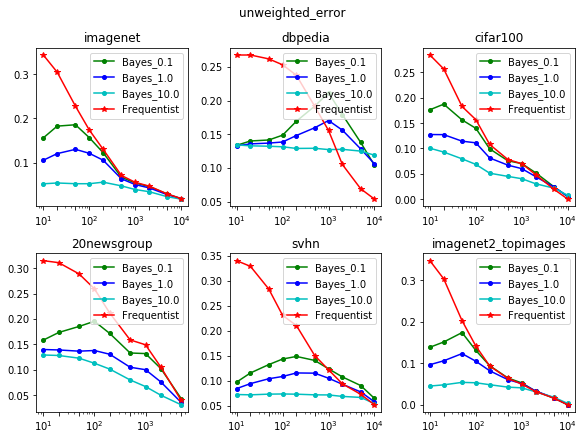

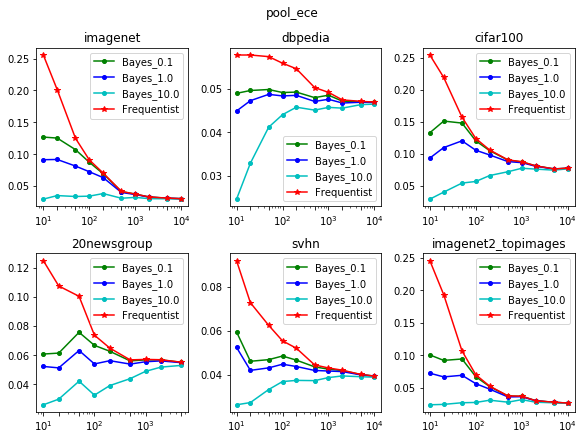

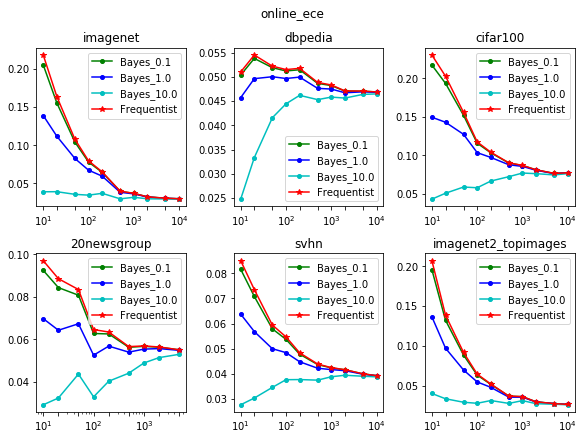

In [125]:
for metric in METRIC_LIST:
    figname = '../figures/accuracy_estimation_error/%s.pdf' % metric
    fig, ax = plt.subplots(2, 3, figsize=(8, 6), constrained_layout=True)
    for idx, dataset in enumerate(DATASET_LIST):
        ax[idx//3, idx% 3].set_title('%s' % dataset)
        if dataset == '20newsgroup':
            x = N_list[:-1]
        else:
            x = N_list
        result_slice = results[(results.metric == metric) & (results.dataset == dataset)]
        y_frequentist = result_slice[result_slice.model_type == 'frequentist'][x].values[0]
        result_slice = result_slice[result_slice.model_type == 'bayesian']
        y_bayesian_01 = result_slice[result_slice.pseudo_n == 0.1][x].values[0]
        y_bayesian_1 = result_slice[result_slice.pseudo_n == 1.0][x].values[0]
        y_bayesian_10 = result_slice[result_slice.pseudo_n == 10.0][x].values[0]
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_01, 'o', ls='-', ms=4, color = 'g', label='Bayes_0.1')
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_1, 'o', ls='-', ms=4, color = 'b', label='Bayes_1.0')
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_10, 'o', ls='-', ms=4, color = 'c', label='Bayes_10.0')
        ax[idx//3, idx% 3].semilogx(x, y_frequentist, '*', ls='-', ms=6, color = 'r', label='Frequentist')
        ax[idx//3, idx% 3].set_xticks(x)
        ax[idx//3, idx% 3].legend()
    plt.suptitle(metric)
    fig.savefig(figname)